# <center> Decision Trees & Random Forests </center>
<center>
        Shan-Hung Wu & DataLab
        <br>
        Fall 2023
</center>

In [1]:
# inline plotting instead of popping out
%matplotlib inline

import os
from IPython.display import display

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_wine, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

The <b>Decision Trees</b> and <b>Random Forests</b> are two versatile machine learning models that are applicable to many machine learning tasks. In this lab, we will apply them to the classification problem and the dimension reduction problem using the <a href='https://archive.ics.uci.edu/ml/datasets/Wine'>Wine</a> dataset that we have being using in our last lab.

## General Machine Learning Steps

Before we start, let's review the general machine learning steps:
1. Data collection, preprocessing (e.g., integration, cleaning, etc.), and exploration.
    - Split a dataset into the **training** and **testing** datasets.
2. Model development:
    - Assume a **model** $\{f\}$ that is a collection of candidate functions $f$’s (representing posteriori knowledge) we want to discover. Let's assume that each $f$ is parametrized by $\boldsymbol{w}$.
    - Define a **cost function** $C(\boldsymbol{w})$  that measures "how good a particular $f$ can explain the training data." The lower the cost function the better.
3. **Training**: employ an algorithm that finds the best (or good enough) function $f^∗$  in the model that minimizes the cost function over the training dataset.
4. **Testing**: evaluate the performance of the learned $f^*$ using the testing dataset.
5. Apply the model in the real world.

## Decision Tree Classification

Now, consider a classification task defined over the Wine dataset: to predict the type (class label) of a wine (data point) based on its 13 constituents (attributes / variables / features). Followings are the steps we are going to perform:

1. Randomly split the Wine dataset into the training dataset $\mathbb{X}^{\text{train}}=\{(\boldsymbol{x}^{(i)},y^{(i)})\}_{i}$ and testing dataset $\mathbb{X}^{\text{test}}=\{(\boldsymbol{x}'^{(i)},y'^{(i)})\}_{i}$.
2. Model development:
    - Model: $\{f(x)=y\}$ where each $f$ represents a decision tree.
    - Cost function: the <b>entropy</b> (impurity) of class labels of data corresponding to the leaf nodes.
3. Training: to grow a tree $f^∗$ by recursively splitting the leaf nodes such that each split leads to the maximal $information$ $gain$ over the corresponding training data.
4. Testing: to calculate the <b>prediction accuracy</b> $$\frac{1}{\vert\mathbb{X}^{\text{test}}\vert}\Sigma_{i}1(\boldsymbol{x}'^{(i)};f^{*}(\boldsymbol{x}'^{(i)})=y'^{(i)})$$ using the testing dataset.
5. Visualize $f^∗$ so we can interpret the meaning of rules.

### Preparing Data
Let's prepare the training and testing datasets:

In [2]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine//wine.data', header=None)

df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

display(df.head())

X = df.drop(labels='Class label', axis=1)
y = df['Class label']
#X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values

# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels:', np.unique(y))

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# Training data points: 124
# Testing data points: 54
Class labels: [1 2 3]


### Training
<p>We have already decided our model to be the decision trees, so let's proceed to the training step. The <a href='http://scikit-learn.org/stable/'>Scikit-learn</a> package provides the off-the-shelf implementation of various machine learning models / algorithms, including the decision trees. We can simply use it to build a decision tree for our training set:</p>

In [3]:
# criterion : impurity function
# max_depth : maximum depth of tree
# random_state : seed of random number generator
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

<p>NOTE: you are not required to standardize the data features before building a decision tree (or a random forest) because the information gain of a cutting point does not change when we scale values of an attribute.</p>

### Testing
<p>Now we have a tree. Let's apply it to our testing set to see how it performs:</p>

In [4]:
y_pred = tree.predict(X_test)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy (tree): %.2f' % ((y_test == y_pred).sum() / y_test.shape[0]))

# a more convenient way to evaluate a trained model is to use the sklearn.metrics 
from sklearn.metrics import accuracy_score
print('Accuracy (tree, sklearn): %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 2
Accuracy (tree): 0.96
Accuracy (tree, sklearn): 0.96


<p>We get a 96% accuracy. That's pretty good!</p>

### Visualization
<p>Decision trees are an attractive model if we care about the interpretability of a model. By visualizing a tree, we can understand how a prediction is made by breaking down a classification rule into a series of questions about the data features.</p>
<p>A nice feature of the <code>DecisionTreeClassifier</code> in Scikit-learn is that it allows us to export the decision tree as a <code>.dot</code> file after training, which we can visualize using the <a href='http://www.graphviz.org/'>GraphViz</a> program. This program is freely available on Linux, Windows, and Mac OS X. For exmaple, if you have <a href='https://www.anaconda.com/download/'>Anaconda</a> installed, you can get GraphViz by simply executing the following command in command line:</p>
<p><code>> conda install graphviz</code></p>
<p>After installing GraphViz, we can create the <code>tree.dot</code> file:</p>

In [5]:
if not os.path.exists("./output/") : os.mkdir("./output/")
export_graphviz(
    tree,
    out_file='./output/tree.dot', 
    feature_names=X.columns.values
)

<p>and then convert the <code>tree.dot</code> file into a PNG file by executing the following GraphViz command from the command line under the same directory where <code>tree.dot</code> resides:</p>
<p><code>> dot -Tpng tree.dot -o fig-tree.png</code></p>
<p>Here is the visualized tree:</p>
<p><img src='./output/fig-tree.png'></p>
<p>As we can see, the criterion 'Flavanoids &lt;= 1.575' is effective in separating the data points of the first class from those of the third class. By looking into the other criteria, we also know how to separate data points of the second class from the rests.</p>

## Random Forests

Random forests have gained huge popularity in applications of machine learning during the last decade due to their good classification performance, scalability, and ease of use. Intuitively, a random forest can be considered as an ensemble of decision trees. The idea behind **ensemble** learning is to combine weak learners to build a more robust model, a strong learner, that has a better generalization performance. The random forest algorithm can be summarized in four simple steps:

1. Randomly draw $M$ **bootstrap samples** from the training set with replacement.
2. Grow a decision tree from the bootstrap samples. At each node:
    - **Randomly select** $K$ **features** without replacement.
    - Split the node by finding the best cut among the selected features that maximizes the information gain.
3. Repeat the steps 1 to 2 $T$ times to get $T$ trees.
4. Aggregate the predictions made by different trees via the majority vote.

Although random forests don't offer the same level of interpretability as decision trees, a big advantage of random forests is that we don't have to worry so much about the depth of trees since the majority vote can "absorb" the noise from individual trees. Therefore, we typically don't need to prune the trees in a random forest. The only parameter that we need to care about in practice is the number of trees $T$ at step 3. Generally, the larger the number of trees, the better the performance of the random forest classifier at the expense of an increased computational cost. Another advantage is that the computational cost can be distributed to multiple cores / machines since each tree can grow independently.

### Training
<p>We can build a random forest by using the <code>RandomForestClassifier</code> in Scikit-learn:</p>

In [6]:
# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy (forest): %.2f' % accuracy_score(y_test, y_pred))

Accuracy (forest): 0.98


<p>We get a slightly improved accuracy 98%!</p>

NOTE: in most implementations, including the `RandomForestClassifier` implementation in Scikit-learn, the bootstrap sample size $M$ is equal to the number of samples $N$ in the original training set by default. For the number of features $K$ to select at each split, the default that is used in Scikit-learn (and many other implementations) is  $K=\sqrt{D}$ , where $D$ is the number of features of data points.

## Computing Feature Importance
<p>In addition to classification, a random forest can be used to calculate the <b>feature importance</b>. Using a random forest, we can measure feature importance as the averaged information gain (impurity decrease) computed from all decision trees in the forest.</p>

 1) Flavanoids                     0.188736
 2) OD280/OD315 of diluted wines   0.162445
 3) Proline                        0.158390
 4) Color intensity                0.154620
 5) Alcohol                        0.102004
 6) Hue                            0.065470
 7) Total phenols                  0.049602
 8) Alcalinity of ash              0.030379
 9) Proanthocyanins                0.023283
10) Malic acid                     0.022439
11) Magnesium                      0.018800
12) Nonflavanoid phenols           0.012507
13) Ash                            0.011325


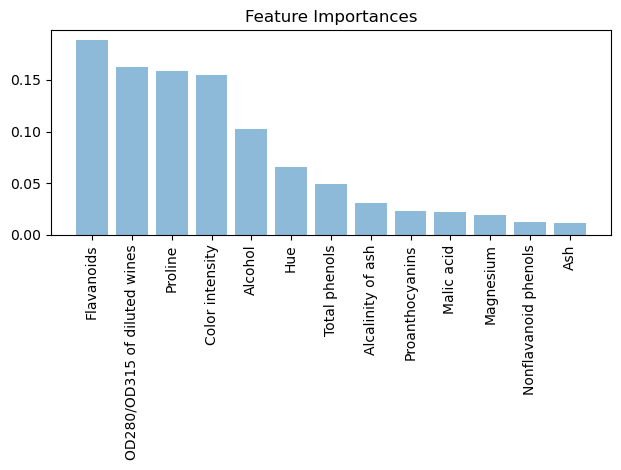

In [7]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.tight_layout()
plt.savefig('./output/fig-forest-feature-importances.png', dpi=300)
plt.show()

From the above figure, we can see that "Flavanoids", "OD280/OD315 of diluted wines", "Proline", and "Color intensity" are the most important features to classify the Wine dataset. This may change if we choose a different number of trees $T$ in a random foreest. For example, if we set $T=10000$, then the most important feature becomes "Color intensity."

### Feature Selection
By discarding the unimportant features, we can reduce the dimension of data points and compress data. For example, $Z_{Forest}$ is a compressed 2-D dataset that contains only the most important two features "Flavanoids" and "OD280/OD315 of diluted wines:"

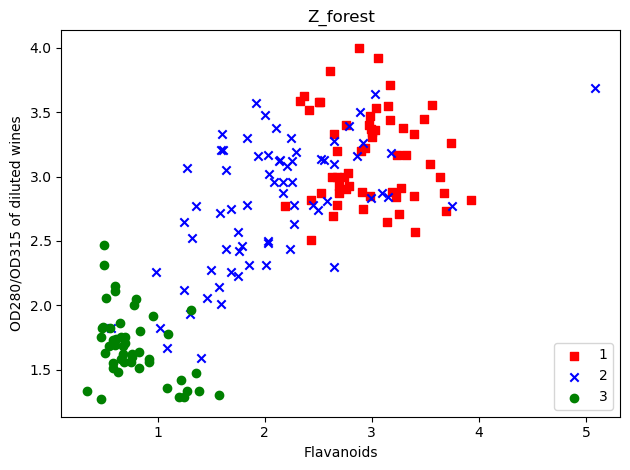

In [8]:
Z_forest = X[['Flavanoids', 'OD280/OD315 of diluted wines']].values

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y.values), colors, markers):
    plt.scatter(Z_forest[y.values==l, 0], 
                Z_forest[y.values==l, 1], 
                c=c, label=l, marker=m)

plt.title('Z_forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-forest-z.png', dpi=300)
plt.show()

It is worth mentioning that Scikit-learn also implements a class called <code>SelectFromModel</code> that helps you select features based on a user-specified threshold, which is useful if we want to use the <code>RandomForestClassifier</code> as a feature selector. For example, we could set the threshold to 0.16 to get $Z_{Forest}$ :

In [9]:
# put prefitted RandomForestClassifier "forest" into SelectFromModel
sfm = SelectFromModel(forest, threshold=0.16, prefit=True)
Z_forest_alt = sfm.transform(X.values)

for f in range(Z_forest_alt.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

 1) Flavanoids                     0.188736
 2) OD280/OD315 of diluted wines   0.162445


## Dimension Reduction: PCA vs. Random Forest
So far, we have seen two dimension reduction techniques: PCA and feature selection based on Random Forest. PCA is an <i>unsupervised</i> dimension reduction technique since it does not require the class labels; while the latter is a <i>supervised</i> dimension reduction technique as the labels are used for computing the information gain for each node split. However, PCA is a <b>feature extraction</b> technique (as opposed to <b>feature selection</b>) in the sense that a reduced feature may not be identical to any of the original features. Next, let's build classifiers for the two compressed datasets $Z_{PCA}$ and $Z_{Forest}$ and compare their performance:

In [10]:
# train a decision tree based on Z_forest

Z_forest_train, Z_forest_test, y_forest_train, y_forest_test = train_test_split(
    Z_forest, y, test_size=0.3, random_state=0)

tree_forest = DecisionTreeClassifier(criterion='entropy', 
                                     max_depth=3, 
                                     random_state=0)
tree_forest.fit(Z_forest_train, y_forest_train)

y_forest_pred = tree_forest.predict(Z_forest_test)
print('Accuracy (tree_forest): %.2f' % accuracy_score(y_forest_test, y_forest_pred))

# train a decision tree based on Z_pca

# load Z_pca that we have created in our last lab
Z_pca= np.load('./output/Z_pca.npy')
# random_state should be the same as that used to split the Z_forest
Z_pca_train, Z_pca_test, y_pca_train, y_pca_test = train_test_split(
    Z_pca, y, test_size=0.3, random_state=0)

tree_pca = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=3, 
                                  random_state=0)
tree_pca.fit(Z_pca_train, y_pca_train)

y_pca_pred = tree_pca.predict(Z_pca_test)
print('Accuracy (tree_pca): %.2f' % accuracy_score(y_pca_test, y_pca_pred))

Accuracy (tree_forest): 0.83
Accuracy (tree_pca): 0.96


<p>As we can see, the tree grown from PCA-compressed data yields the same accuracy 96% as that of the tree for uncompressed data. Furthermore, it performs much better than the tree grown from the selected features advised by a random forest. This shows that PCA, a feature extraction technique, is effective in preserving "information" in a dataset when the compressed dimension is very low (2 in this case). The same holds for the Random Forest classifiers:</p>

In [11]:
# train a random forest based on Z_forest

forest_forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest_forest.fit(Z_forest_train, y_forest_train)

y_forest_pred = forest_forest.predict(Z_forest_test)
print('Accuracy (forest_forest): %.2f' % accuracy_score(y_forest_test, y_forest_pred))


# train a random forest based on Z_pca

forest_pca = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest_pca.fit(Z_pca_train, y_pca_train)

y_pca_pred = forest_pca.predict(Z_pca_test)
print('Accuracy (forest_pca): %.2f' % accuracy_score(y_pca_test, y_pca_pred))

Accuracy (forest_forest): 0.67
Accuracy (forest_pca): 0.98


### Further Visualization
When the data dimension is 2, we can easily plot the decision boundaries of a classifier. Let's take a look at the decision boundaries of the Decision Tree and Random Forest classifiers we have for $Z_{PCA}$ and $Z_{Forest}$. First, we define a utility function for plotting decision boundaries:

In [12]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c=[cmap(i - 1) for i in y_test],
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

<p>Next, we plot the decision boundaries by combining the training and testing sets deterministically:</p>

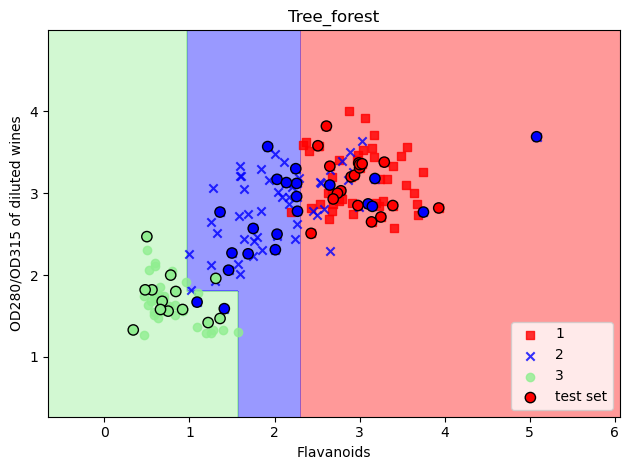

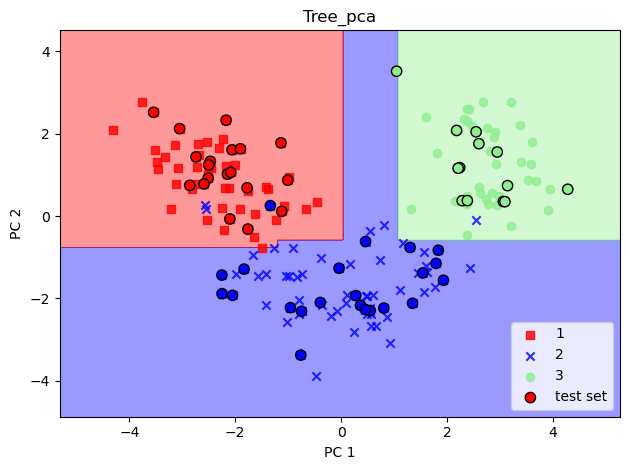

In [13]:
# plot boundaries of tree_forest
Z_forest_combined = np.vstack((Z_forest_train, Z_forest_test))
y_forest_combined = np.hstack((y_forest_train, y_forest_test))
plot_decision_regions(
        Z_forest_combined, 
        y_forest_combined, 
        classifier = tree_forest, 
        test_idx = range(
            y_forest_train.shape[0],
            y_forest_train.shape[0] + y_forest_test.shape[0]
        )
)

plt.title('Tree_forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-tree-forest.png', dpi=300)
plt.show()

# plot boundaries of tree_pca
Z_pca_combined = np.vstack((Z_pca_train, Z_pca_test))
y_pca_combined = np.hstack((y_pca_train, y_pca_test))
plot_decision_regions(
    Z_pca_combined, 
    y_pca_combined, 
    classifier = tree_pca, 
    test_idx = range(
        y_pca_train.shape[0],
        y_pca_train.shape[0] + y_pca_test.shape[0]
    )
)

plt.title('Tree_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-tree-pca.png', dpi = 300)
plt.show()

As we can see, the decision boundaries of a decision tree are always axis-aligned. This means that if a "true" boundary is not axis-aligned, the tree needs to be very deep to approximate the boundary using the "staircase" one. We can see this from the random forests:

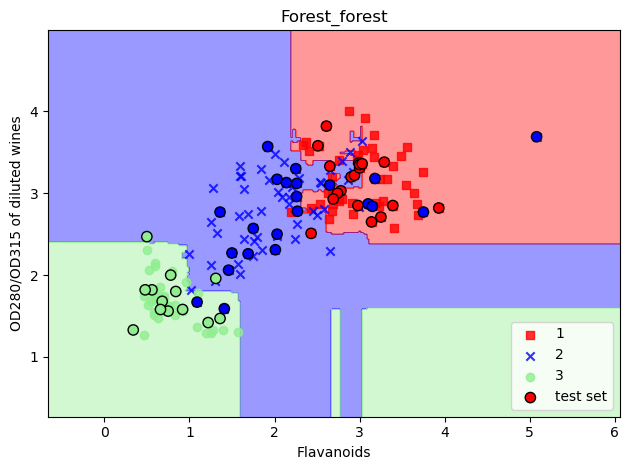

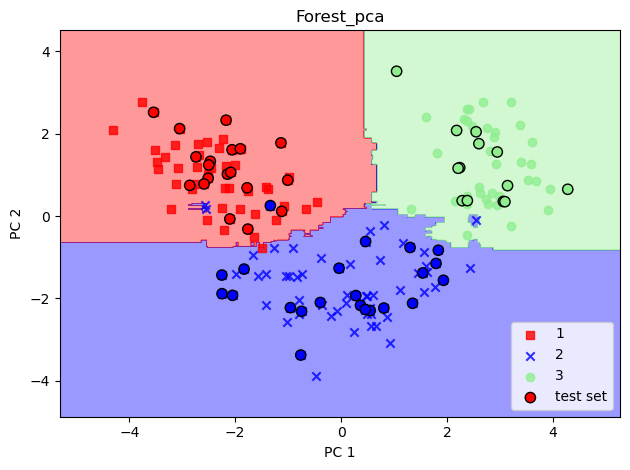

In [14]:
# plot boundaries of tree_forest
plot_decision_regions(Z_forest_combined, 
                      y_forest_combined, 
                      classifier=forest_forest, 
                      test_idx=range(y_forest_train.shape[0],
                                     y_forest_train.shape[0] + y_forest_test.shape[0]))

plt.title('Forest_forest')
plt.xlabel('Flavanoids')
plt.ylabel('OD280/OD315 of diluted wines')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-forest-forest.png', dpi=300)
plt.show()

# plot boundaries of tree_pca
plot_decision_regions(Z_pca_combined, 
                      y_pca_combined, 
                      classifier=forest_pca, 
                      test_idx=range(y_pca_train.shape[0],
                                     y_pca_train.shape[0] + y_pca_test.shape[0]))

plt.title('Forest_pca')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('./output/fig-boundary-forest-pca.png', dpi=300)
plt.show()

# <center>Assignment</center>

We try to make predition from another dataset <a href='https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)'>breast cancer wisconsin</a>. But there are too many features in this dataset. Please try to improve accuracy per feature $$\frac{\text{Accuracy}}{\text{\# Features}}$$

HINT:
- You can improve the ratio by picking out several important features.
- The ratio can be improved from 0.03 up to 0.44.

In [15]:
"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
"""

# load the breast_cancer dataset
init_data = load_breast_cancer()
(X, y) = load_breast_cancer(return_X_y=True)
# X = pd.DataFrame(data=X, columns=init_data['feature_names'])
# y = pd.DataFrame(data=y, columns=['label'])

# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy per feature: %.2f' % (accuracy_score(y_test, y_pred)/X.shape[1]))

Accuracy: 0.98
Accuracy per feature: 0.03


## Requirements:

- Submit to **eeclass** with your code named ```Lab03_{student-id}.ipynb``` (e.g. ```Lab03_110069999.ipynb```).
- **The code file should only contain the Assignment part.**
- Remember to save the file after you rendered the output images in your notebook.
- Deadline: **2024-01-07 (Sun) 23:59**.